# Gibson Lanni Model

In [1]:
import os
import sys
import numpy as np
from numpy.random import randint, choice, randn
import torch
import skimage.morphology
from skimage.morphology import ball, octahedron, cube

import scipy.special

from matplotlib import cm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.distributions as distin
import torch.nn.functional as F
from   scipy.stats import lognorm
import torch.special as S
from fft_conv_pytorch import fft_conv

In [2]:
def make_ball(r = 20, datasize = [128, 128, 128]):
    data     = np.zeros(datasize)
    datasize = np.array(datasize)
    s        = 'ball' # 'octahedron', 'cube'
    form     = getattr(skimage.morphology, s)(r).astype(np.float32)
    z, x, y  = datasize // 2 - r
    z_max    = min(z + form.shape[0], datasize[0])
    x_max    = min(x + form.shape[1], datasize[1])
    y_max    = min(y + form.shape[2], datasize[2])
    data[z : z + form.shape[0],
         x : x + form.shape[1],
         y : y + form.shape[2],]\
    += \
    form[0 : z_max - z        ,
         0 : x_max - x        ,
         0 : y_max - y        ,]
    data = data > 0
    data = torch.from_numpy(data).to(torch.float32)
    data = data.unsqueeze(0)
    return data

In [3]:
data = make_ball(r=20, datasize=[240, 128, 128])
nd_data = data.detach().numpy().copy()

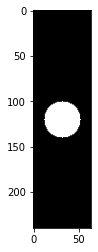

In [4]:
plt.imshow(data[0, :, 64, 32:96], cmap='gray', vmax=1, vmin=0)

In [5]:
dirpath = "_beads_roi_extracted_stackreg"
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))][:-1]
print(beadslist)
label = torch.load(beadslist[0], map_location="cuda").to(torch.float32)

['_beads_roi_extracted_stackreg/beads_001_roi000.pt', '_beads_roi_extracted_stackreg/beads_001_roi001.pt', '_beads_roi_extracted_stackreg/beads_001_roi002.pt', '_beads_roi_extracted_stackreg/beads_001_roi003.pt', '_beads_roi_extracted_stackreg/beads_001_roi004.pt', '_beads_roi_extracted_stackreg/beads_002_roi000.pt', '_beads_roi_extracted_stackreg/beads_002_roi001.pt', '_beads_roi_extracted_stackreg/beads_002_roi002.pt']


In [6]:
loss_fn = nn.MSELoss()

def normalize(array):
    return array / torch.sum(array)

def train_loop(obj, model, label, optimizer, epoch):
    for _ in range(epoch):
        if obj.dim() == 4:
            obj = obj.unsqueeze(0)
        x = model(obj)
        if x.dim() == 5:
            x = x.squeeze(0)
        loss = loss_fn(x, label)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        if _ % 10 == 0:
            print(f'epoch {_}, loss {loss:.8f}')
    return loss.item()

In [12]:

class Emission(nn.Module):
    def __init__(self, mu_z, sig_z, log_ez0):
        super().__init__()
        self.mu_z     = mu_z
        self.sig_z    = sig_z
        self.log_ez0  = log_ez0

    def forward(self, x):
        x = x * torch.exp(self.log_ez0)
        return x


class Intensity(nn.Module):
    def __init__(self, gamma, image_size, initial_depth, voxel_size, scale,
                 device):
        super().__init__()
        init_d = initial_depth
        im_z,  \
        im_x,  \
        im_y   = image_size
        end_d  = im_z * voxel_size * scale
        depth  = init_d \
               + torch.linspace(0, end_d, im_z,).view(-1,1,1,).to(device)
        _intensity = torch.exp(-2 * depth * gamma) # gamma = 0.005
        self._intensity = _intensity.expand(image_size)

    def forward(self, x):
         x = x * self.intensity
         return x

    @property
    def intensity(self):
        return self._intensity


class Blur(nn.Module):
    def __init__(self, params, device, use_fftconv=False):
        super().__init__()
        self.params      = params
        self.device      = device
        self.use_fftconv = use_fftconv
        gibson_lanni_exi = GibsonLanniModel(params)
        self.psf_rz      = nn.Parameter(torch.tensor(gibson_lanni_exi.PSF_rz, requires_grad=True).float().to(self.device))
        self.psf_rz_s0   = self.psf_rz.shape[0]
        xy               = torch.meshgrid(torch.arange(params["size_y"]),
                                          torch.arange(params["size_x"]),
                                          indexing='ij')
        #self.psf      = nn.Parameter(torch.zeros((self.params["size_z"], self.params["size_x"],  self.params["size_y"]), device=self.device), requires_grad=True)
        r = torch.tensor(gibson_lanni_exi.r)
        x0 = (params["size_x"] - 1) / 2
        y0 = (params["size_y"] - 1) / 2
        r_pixel = torch.sqrt((xy[1] - x0) ** 2 + (xy[0] - y0) ** 2) * params["res_lateral"]
        rs0, = r.shape
        self.rps0, self.rps1 = r_pixel.shape
        r_e = r[:, None, None].expand(rs0, self.rps0, self.rps1)
        r_pixel_e = r_pixel[None].expand(rs0, self.rps0, self.rps1)
        r_index = torch.argmin(torch.abs(r_e- r_pixel_e), dim=0)
        r_index_fe = r_index.flatten().expand(self.psf_rz_s0, -1)
        self.r_index_fe = r_index_fe.to(self.device)
        self.z_pad   = int((params["size_z"] - self.params["res_axial"] // self.params["res_lateral"] + 1) // 2)
        self.x_pad   = (params["size_x"]) // 2
        self.y_pad   = (params["size_y"]) // 2
        self.stride  = (params["scale"], 1, 1)
        
    def forward(self, x):
        psf = torch.gather(self.psf_rz, 1, self.r_index_fe)
        psf = psf / torch.sum(psf)
        psf = psf.reshape(self.psf_rz_s0, self.rps0, self.rps1)
        if self.use_fftconv:
            _x   = fft_conv(signal  = x                                    ,
                            kernel  = psf                                  ,
                            stride  = self.stride                          ,
                            padding = (self.z_pad, self.x_pad, self.y_pad,),
                            )
        else:
            _x   = F.conv3d(input   = x                                    ,
                            weight  = psf                                  ,
                            stride  = self.stride                          ,
                            padding = (self.z_pad, self.x_pad, self.y_pad,),
                            )
        return _x

    def show_psf_3d(self):
        psf = torch.gather(self.psf_rz, 1, self.r_index_fe)
        psf = psf / torch.sum(psf)
        psf = psf.reshape(self.psf_rz_s0, self.rps0, self.rps1)
        return psf
    

class GaussianModel():
    def __init__(self, params):
        size_x = params["size_x"]
        size_y = params["size_y"]
        size_z = params["size_z"]
        bet_xy = params["bet_xy"]
        bet_z = params["bet_z" ]
        x0 = (size_x - 1) / 2
        y0 = (size_y - 1) / 2
        z0 = (size_z - 1) / 2
        max_radius = round(np.sqrt((size_x - x0) * (size_x - x0) + (size_y - y0) * (size_y - y0)))
        xy = np.meshgrid(np.arange(params["size_z"]), np.arange(max_radius), indexing="ij")
        distance = np.sqrt((xy[1] / bet_xy) ** 2 + ((xy[0] - z0) / bet_z) ** 2)
        self.psf_rz = np.exp(- distance ** 2)

    def __call__(self):
        return self.psf_rz


class GibsonLanniModel():
    def __init__(self, params):
        size_x = params["size_x"]#256 # # # # param # # # #
        size_y = params["size_y"]#256 # # # # param # # # #
        size_z = params["size_z"]#128 # # # # param # # # #

        # Precision control
        num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
        num_samples  = 1000 # Number of pupil samples along radial direction
        oversampling = 1    # Defines the upsampling ratio on the image space grid for computations

        # Microscope parameters
        NA          = params["NA"]#1.1   # # # # param # # # #
        wavelength  = params["wavelength"]
        M           = params["M"]  #25    # magnification # # # # param # # # #
        ns          = params["ns"] #1.33  # specimen refractive index (RI)
        ng0         = params["ng0"]#1.5   # coverslip RI design value
        ng          = params["ng"] #1.5   # coverslip RI experimental value
        ni0         = params["ni0"]#1.5   # immersion medium RI design value
        ni          = params["ni"] #1.5   # immersion medium RI experimental value
        ti0         = params["ti0"]#150   # microns, working distance (immersion medium thickness) design value
        tg0         = params["tg0"]#170   # microns, coverslip thickness design value
        tg          = params["tg"] #170   # microns, coverslip thickness experimental value
        res_lateral = params["res_lateral"]#0.05  # microns # # # # param # # # #
        res_axial   = params["res_axial"]#0.5   # microns # # # # param # # # #
        pZ          = params["pZ"]       # 2 microns, particle distance from coverslip

        # Scaling factors for the Fourier-Bessel series expansion
        min_wavelength = 0.436 # microns
        scaling_factor = NA * (3 * np.arange(1, num_basis + 1) - 2) * min_wavelength / wavelength
        x0 = (size_x - 1) / 2
        y0 = (size_y - 1) / 2
        max_radius = round(np.sqrt((size_x - x0) * (size_x - x0) + (size_y - y0) * (size_y - y0)))
        r = res_lateral * np.arange(0, oversampling * max_radius) / oversampling
        self.r = r
        a = min([NA, ns, ni, ni0, ng, ng0]) / NA
        rho = np.linspace(0, a, num_samples)

        z = res_axial * np.arange(-size_z / 2, size_z /2) + res_axial / 2

        OPDs = pZ * np.sqrt(ns * ns - NA * NA * rho * rho) # OPD in the sample
        OPDi = (z.reshape(-1,1) + ti0) * np.sqrt(ni * ni - NA * NA * rho * rho) - ti0 * np.sqrt(ni0 * ni0 - NA * NA * rho * rho) # OPD in the immersion medium
        OPDg = tg * np.sqrt(ng * ng - NA * NA * rho * rho) - tg0 * np.sqrt(ng0 * ng0 - NA * NA * rho * rho) # OPD in the coverslip
        W    = 2 * np.pi / wavelength * (OPDs + OPDi + OPDg)
        phase = np.cos(W) + 1j * np.sin(W)
        J = scipy.special.jv(0, scaling_factor.reshape(-1, 1) * rho)
        C, residuals, _, _ = np.linalg.lstsq(J.T, phase.T)
        b = 2 * np.pi * r.reshape(-1, 1) * NA / wavelength
        J0 = lambda x: scipy.special.j0(x)
        J1 = lambda x: scipy.special.j1(x)
        denom = scaling_factor * scaling_factor - b * b
        R = scaling_factor * J1(scaling_factor * a) * J0(b * a) * a - b * J0(scaling_factor * a) * J1(b * a) * a
        R /= denom
        PSF_rz = (np.abs(R.dot(C))**2).T
        self.PSF_rz = PSF_rz / np.max(PSF_rz)

    def __call__(self):
        return self.PSF_rz


class Noise(nn.Module):
    def __init__(self, sig_eps):
        super().__init__()
        self.sig_eps = sig_eps

    def forward(self, x):
        return x


class PreProcess(nn.Module):
    def __init__(self, min, max):
        super().__init__()
        self.min = min
        self.max = max

    def forward(self, x):
        x = torch.clip(x, min=self.min, max=self.max)
        x = (x - self.min) / (self.max - self.min)
        return x


class ImagingProcess(nn.Module):
    def __init__(self, device, params,
                 z, x, y, postmin=0., postmax=1.,
                 mode:str="train", dist="double_exp",
                 apply_hill=False, use_fftconv=False):
        super().__init__()
        self.device = device
        self.z = z
        self.x = x
        self.y = y
        self.postmin = postmin
        self.postmax = postmax
        if mode == "train":
            self.mu_z       = params["mu_z"]
            self.sig_z      = params["sig_z"]
            self.log_ez0    = nn.Parameter((torch.tensor(params["mu_z"] + 0.5 * params["sig_z"] ** 2)).to(device), requires_grad=True)
        elif mode == "dataset":
            self.mu_z    = nn.Parameter(torch.tensor(params["mu_z"  ]), requires_grad=False)
            self.sig_z   = nn.Parameter(torch.tensor(params["sig_z" ]), requires_grad=False)
        else:
            raise(NotImplementedError())
        self.emission   = Emission(mu_z    = self.mu_z ,
                                   sig_z   = self.sig_z,
                                   log_ez0 = self.log_ez0,)
        self.blur       = Blur(params      = params         ,
                               device      = device         ,
                               use_fftconv = use_fftconv    ,)
        self.noise      = Noise(torch.tensor(params["sig_eps"]))
        self.preprocess = PreProcess(min=postmin, max=postmax)


    def forward(self, x):
        x = self.emission(x)
        x = self.blur(x)
        x = self.preprocess(x)
        return x

/tmp/ipykernel_778183/3844105478.py:155: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residuals, _, _ = np.linalg.lstsq(J.T, phase.T)


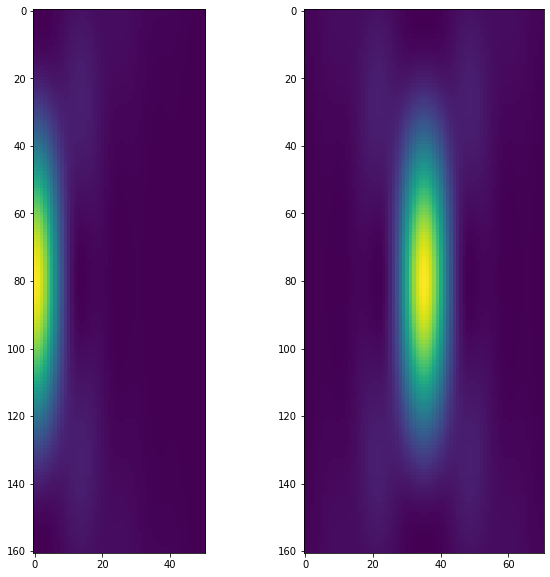

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

params = {"mu_z"       : 0.1               ,
          "sig_z"      : 0.1               ,
          "size_x"     : 71                ,
          "size_y"     : 71                ,
          "size_z"     : 161               ,
          "mode"       : "gibson"          ,
          "NA"         : 0.80              , # # # # param # # # #
          "wavelength" : 0.910  , # microns # # # # param # # # #
          "M"          : 25     , # magnification # # # # param # # # #
          "ns"         : 1.4   , # specimen refractive index (RI)
          "ng0"        : 1.5    , # coverslip RI design value
          "ng"         : 1.5    , # coverslip RI experimental value
          "ni0"        : 1.5    , # immersion medium RI design value
          "ni"         : 1.5    , # immersion medium RI experimental value
          "ti0"        : 150    , # microns, working distance (immersion medium thickness) design value
          "tg0"        : 170    , # microns, coverslip thickness design value
          "tg"         : 170    , # microns, coverslip thickness experimental value
          "res_lateral": 0.05   , # microns # # # # param # # # #
          "res_axial"  : 0.05   , # microns # # # # param # # # #
          "pZ"         : 0      , # microns, particle distance from coverslip
          "sig_eps"    : 0.01   ,
          "scale"      : 10     ,
          }

blur = ImagingProcess(device       = device           ,
                      params       = params           ,
                      z            = params["size_z"] ,
                      x            = params["size_x"] ,
                      y            = params["size_y"] ,
                      mode         = "train"          ,
                      dist         = "gaussian"       ,
                      apply_hill   = False            ,
                      use_fftconv  = True             ,
                      )
psf_rz = blur.blur.psf_rz.detach().cpu().numpy()
psf_3d = blur.blur.show_psf_3d().detach().cpu().numpy()
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(psf_rz)
ax2.imshow(psf_3d[:, psf_3d.shape[1]//2])
plt.show()